In [1]:
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, Image, HTML
import h5py

plt.rcParams['figure.figsize'] = (16.0, 4.0)
%matplotlib inline

In [2]:
from fastai.vision.all import *
from fastai.text.all import *

In [3]:
!python --version

Python 3.10.12


In [4]:
'''import urllib.request

urllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/train.tar.gz", "/kaggle/working/train.tar.gz")
urllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/test.tar.gz", "/kaggle/working/test.tar.gz")
urllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/extra.tar.gz", "/kaggle/working/extra.tar.gz")'''

'import urllib.request\n\nurllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/train.tar.gz", "/kaggle/working/train.tar.gz")\nurllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/test.tar.gz", "/kaggle/working/test.tar.gz")\nurllib.request.urlretrieve("http://ufldl.stanford.edu/housenumbers/extra.tar.gz", "/kaggle/working/extra.tar.gz")'

In [5]:
data='/kaggle/working'

In [6]:
'''def extract_tarball(filename, force=False):
    """ Helper function for extracting tarball files
    """
    # Drop the file extension
    root = filename.split('.')[0] 
    
    # If file is already extracted - return
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
        return
    
    # If file is a tarball file - extract it
    if (filename.endswith("tar.gz")):
        print("Extracting %s ..." % filename)
        tar = tarfile.open(filename, "r:gz")
        tar.extractall()
        tar.close()
        
        
# Get the directory listing for the dataset folder
ls_data = [f for f in os.listdir(data) if 'tar.gz' in f]
        
# cd data
os.chdir(data)

# Extract the tarballs
extract_tarball(ls_data[0])
extract_tarball(ls_data[1])
extract_tarball(ls_data[2])
    
# cd ..
os.chdir(os.path.pardir)'''

'def extract_tarball(filename, force=False):\n    """ Helper function for extracting tarball files\n    """\n    # Drop the file extension\n    root = filename.split(\'.\')[0] \n    \n    # If file is already extracted - return\n    if os.path.isdir(root) and not force:\n        print(\'%s already present - Skipping extraction of %s.\' % (root, filename))\n        return\n    \n    # If file is a tarball file - extract it\n    if (filename.endswith("tar.gz")):\n        print("Extracting %s ..." % filename)\n        tar = tarfile.open(filename, "r:gz")\n        tar.extractall()\n        tar.close()\n        \n        \n# Get the directory listing for the dataset folder\nls_data = [f for f in os.listdir(data) if \'tar.gz\' in f]\n        \n# cd data\nos.chdir(data)\n\n# Extract the tarballs\nextract_tarball(ls_data[0])\nextract_tarball(ls_data[1])\nextract_tarball(ls_data[2])\n    \n# cd ..\nos.chdir(os.path.pardir)'

In [7]:
#import h5py


class DigitStructWrapper:
    """
    Wrapper for the H5PY digitStruct files from the SVHN dataset

    Creates an array of dictionaries containing the filename and bounding boxes for every digit in the image.

    Adapted from https://github.com/hangyao
    """

    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def get_name(self, n):
        """Return the name of the n(th) digit struct"""
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]][()]])

    def get_attribute(self, attr):
        """Helper function for dealing with one vs. multiple bounding boxes"""
        if (len(attr) > 1):
            attr = [self.inf[attr[j].item()][0][0] for j in range(len(attr))]
        else:
            attr = [attr[([0][0])]]
        return attr

    def get_bbox(self, n):
        """Return a dict containing the data from the n(th) bbox"""
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.get_attribute(self.inf[bb]["height"])
        bbox['label'] = self.get_attribute(self.inf[bb]["label"])
        bbox['left'] = self.get_attribute(self.inf[bb]["left"])
        bbox['top'] = self.get_attribute(self.inf[bb]["top"])
        bbox['width'] = self.get_attribute(self.inf[bb]["width"])
        return bbox

    def get_item(self, n):
        """Return the name and bounding boxes of a single image"""
        s = self.get_bbox(n)
        s['name'] = self.get_name(n)
        return s

    def unpack(self):
        """Returns a list of dicts containing all the bounding boxes"""
        return [self.get_item(i) for i in range(len(self.digitStructName))]

    def unpack_all(self):
        pictDat = self.unpack()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = {'filename': pictDat[i]["name"]}
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label'] = pictDat[i]['label'][j]
                figure['left'] = pictDat[i]['left'][j]
                figure['top'] = pictDat[i]['top'][j]
                figure['width'] = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [8]:
#from unpacker import DigitStructWrapper

def get_bounding_boxes(start_path = '.'):
    """ Extracts a bounding box file and returns a dictionary
    """
    return DigitStructWrapper(start_path).unpack_all()

# Extract the bounding boxes (this will take a while!)
train_bbox = get_bounding_boxes('/kaggle/input/street-view-house-numbers/train_digitStruct.mat')
test_bbox = get_bounding_boxes('/kaggle/input/street-view-house-numbers/test_digitStruct.mat')
extra_bbox = get_bounding_boxes('/kaggle/input/street-view-house-numbers/extra_digitStruct.mat')

# Display the information stored about an individual image

print(json.dumps(train_bbox[0], indent=2))

{
  "filename": "1.png",
  "boxes": [
    {
      "height": 219.0,
      "label": 1.0,
      "left": 246.0,
      "top": 77.0,
      "width": 81.0
    },
    {
      "height": 219.0,
      "label": 9.0,
      "left": 323.0,
      "top": 81.0,
      "width": 96.0
    }
  ]
}


In [9]:
(train_bbox[0])

{'filename': '1.png',
 'boxes': [{'height': 219.0,
   'label': 1.0,
   'left': 246.0,
   'top': 77.0,
   'width': 81.0},
  {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]}

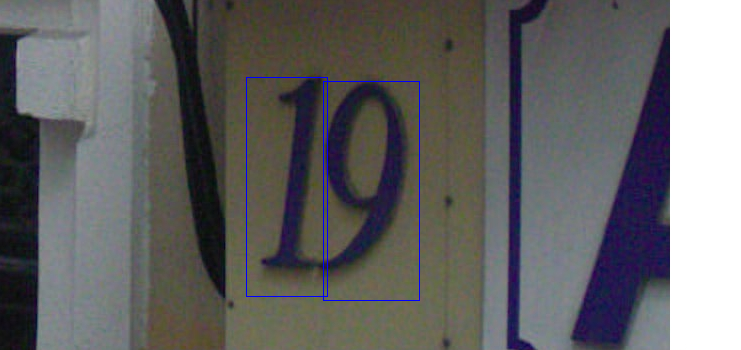

In [10]:
from PIL import Image, ImageDraw

def display_bounding_boxes(img, bounding_boxes):
    """Displays an image and overlays the bounding boxes
    """
    # Opens and identifies the given image file
    image = Image.open(img)
    
    # Use draw module can be used to annotate the image
    draw = ImageDraw.Draw(image)
    
    for b in bounding_boxes:
        
        # Bounding box rectangle [x0, y0, x1, y1]
        rectangle = [b['left'], b['top'], b['left'] + b['width'], b['top'] + b['height']]
        
        # Draw a rectangle on top of the image
        draw.rectangle(rectangle, outline="blue")
        
    # Return altered image    
    return image


# Select an image and the corresponding boxes
image = '/kaggle/input/street-view-house-numbers/train/train/1.png'
image_bounding_boxes = train_bbox[0]['boxes']
     
# Display image with bounding boxes
display_bounding_boxes(image, image_bounding_boxes)

In [11]:
def dict_to_dataframe(image_bounding_boxes, path):
    """ Helper function for flattening the bounding box dictionary
    """
    # Store each bounding box
    boxes = []
    
    # For each set of bounding boxes
    for image in image_bounding_boxes:
        
        # For every bounding box
        for bbox in image['boxes']:
            
            # Store a dict with the file and bounding box info
            boxes.append({
                    'filename': path + image['filename'],
                    'label': bbox['label'],
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left']})
            
    # return the data as a DataFrame
    return pd.DataFrame(boxes)


# We store the bounding boxes here
bbox_file = '/kaggle/input/bounding-boxes/bounding_boxes.csv'

if not os.path.isfile(bbox_file):
    
    # Extract every individual bounding box as DataFrame  
    train_df = dict_to_dataframe(train_bbox, '/kaggle/input/street-view-house-numbers/train/train/')
    test_df = dict_to_dataframe(test_bbox, '/kaggle/input/street-view-house-numbers/test/test/')
    extra_df = dict_to_dataframe(extra_bbox, '/kaggle/input/street-view-house-numbers/extra/extra/')

    print("Training", train_df.shape)
    print("Test", test_df.shape)
    print("Extra", extra_df.shape)
    print('')

    # Concatenate all the information in a single file
    df = pd.concat([train_df, test_df, extra_df])
    
    print("Combined", df.shape)

    # Write dataframe to csv
    df.to_csv(bbox_file, index=False)

    # Delete the old dataframes
    #del train_df, test_df, extra_df, train_bbox, test_bbox, extra_bbox
    
else:
    # Load preprocessed bounding boxes
    df = pd.read_csv(bbox_file)

# Display the first 10 rows of dataframe
df.head()

,filename,label,width,height,top,left
0,/kaggle/input/street-view-house-numbers/train/train/1.png,1.0,81.0,219.0,77.0,246.0
1,/kaggle/input/street-view-house-numbers/train/train/1.png,9.0,96.0,219.0,81.0,323.0
2,/kaggle/input/street-view-house-numbers/train/train/2.png,2.0,23.0,32.0,29.0,77.0
3,/kaggle/input/street-view-house-numbers/train/train/2.png,3.0,26.0,32.0,25.0,98.0
4,/kaggle/input/street-view-house-numbers/train/train/3.png,2.0,8.0,15.0,5.0,17.0


In [12]:
df

,filename,label,width,height,top,left
0,/kaggle/input/street-view-house-numbers/train/train/1.png,1.0,81.0,219.0,77.0,246.0
1,/kaggle/input/street-view-house-numbers/train/train/1.png,9.0,96.0,219.0,81.0,323.0
2,/kaggle/input/street-view-house-numbers/train/train/2.png,2.0,23.0,32.0,29.0,77.0
3,/kaggle/input/street-view-house-numbers/train/train/2.png,3.0,26.0,32.0,25.0,98.0
4,/kaggle/input/street-view-house-numbers/train/train/3.png,2.0,8.0,15.0,5.0,17.0
...,...,...,...,...,...,...
630415,/kaggle/input/street-view-house-numbers/extra/extra/202351.png,[6.],[10.],[18.],[4.],[20.]
630416,/kaggle/input/street-view-house-numbers/extra/extra/202352.png,[5.],[24.],[40.],[12.],[10.]
630417,/kaggle/input/street-view-house-numbers/extra/extra/202353.png,2.0,50.0,106.0,50.0,67.0
630418,/kaggle/input/street-view-house-numbers/extra/extra/202353.png,1.0,38.0,106.0,40.0,121.0


In [13]:
'''import os

bbox_file = "/kaggle/working/bounding_boxes.csv"  # Replace with the actual path to your file

if os.path.isfile(bbox_file):
    os.remove(bbox_file)
    print(f"{bbox_file} has been deleted.")
else:
    print(f"{bbox_file} does not exist, so it cannot be deleted.")'''


'import os\n\nbbox_file = "/kaggle/working/bounding_boxes.csv"  # Replace with the actual path to your file\n\nif os.path.isfile(bbox_file):\n    os.remove(bbox_file)\n    print(f"{bbox_file} has been deleted.")\nelse:\n    print(f"{bbox_file} does not exist, so it cannot be deleted.")'

In [14]:
df

,filename,label,width,height,top,left
0,/kaggle/input/street-view-house-numbers/train/train/1.png,1.0,81.0,219.0,77.0,246.0
1,/kaggle/input/street-view-house-numbers/train/train/1.png,9.0,96.0,219.0,81.0,323.0
2,/kaggle/input/street-view-house-numbers/train/train/2.png,2.0,23.0,32.0,29.0,77.0
3,/kaggle/input/street-view-house-numbers/train/train/2.png,3.0,26.0,32.0,25.0,98.0
4,/kaggle/input/street-view-house-numbers/train/train/3.png,2.0,8.0,15.0,5.0,17.0
...,...,...,...,...,...,...
630415,/kaggle/input/street-view-house-numbers/extra/extra/202351.png,[6.],[10.],[18.],[4.],[20.]
630416,/kaggle/input/street-view-house-numbers/extra/extra/202352.png,[5.],[24.],[40.],[12.],[10.]
630417,/kaggle/input/street-view-house-numbers/extra/extra/202353.png,2.0,50.0,106.0,50.0,67.0
630418,/kaggle/input/street-view-house-numbers/extra/extra/202353.png,1.0,38.0,106.0,40.0,121.0


In [15]:
# Rename the columns to more suitable names
df.rename(columns={'left': 'x0', 'top': 'y0'}, inplace=True)
df['x0'] = df['x0'].str.replace(r'[^\d.]', '', regex=True)
df['y0'] = df['y0'].str.replace(r'[^\d.]', '', regex=True)

In [16]:

df['width'] = df['width'].str.replace(r'[^\d.]', '', regex=True)
df['height'] = df['height'].str.replace(r'[^\d.]', '', regex=True)
# Calculate x1 and y1
df['x1'] = pd.to_numeric(df['x0']) + pd.to_numeric(df['width'])
df['y1'] = pd.to_numeric(df['y0']) + pd.to_numeric(df['height'])
df['labels']=df['label']
df['num_digits']=df['label']
# Perform the following aggregations
aggregate = {'x0':'min',
             'y0':'min',
             'x1':'max',
             'y1':'max',
             
              
             'labels': lambda label: list(label),
             'num_digits': 'count'}

# Apply the aggration
df = df.groupby('filename').agg(aggregate).reset_index()
# Fix the column names after aggregation
#df.columns = [x[0] if i < 5 else x[1] for i, x in enumerate(df.columns.values)]

# Display the results
df.head()

,filename,x0,y0,x1,y1,labels,num_digits
0,/kaggle/input/street-view-house-numbers/extra/extra/1.png,24.0,23.0,126.0,126.0,"[4.0, 7.0, 8.0]",3
1,/kaggle/input/street-view-house-numbers/extra/extra/10.png,25.0,5.0,52.0,32.0,"[4.0, 4.0, 4.0]",3
2,/kaggle/input/street-view-house-numbers/extra/extra/100.png,18.0,1.0,46.0,30.0,"[5.0, 3.0, 5.0]",3
3,/kaggle/input/street-view-house-numbers/extra/extra/1000.png,22.0,7.0,36.0,40.0,"[2.0, 6.0]",2
4,/kaggle/input/street-view-house-numbers/extra/extra/10000.png,17.0,11.0,41.0,35.0,"[2.0, 10.0, 10.0]",3


In [17]:
#df.columns = [x[0] if i < 5 else x[1] for i, x in enumerate(df.columns.values)]

In [18]:
df

,filename,x0,y0,x1,y1,labels,num_digits
0,/kaggle/input/street-view-house-numbers/extra/extra/1.png,24.0,23.0,126.0,126.0,"[4.0, 7.0, 8.0]",3
1,/kaggle/input/street-view-house-numbers/extra/extra/10.png,25.0,5.0,52.0,32.0,"[4.0, 4.0, 4.0]",3
2,/kaggle/input/street-view-house-numbers/extra/extra/100.png,18.0,1.0,46.0,30.0,"[5.0, 3.0, 5.0]",3
3,/kaggle/input/street-view-house-numbers/extra/extra/1000.png,22.0,7.0,36.0,40.0,"[2.0, 6.0]",2
4,/kaggle/input/street-view-house-numbers/extra/extra/10000.png,17.0,11.0,41.0,35.0,"[2.0, 10.0, 10.0]",3
...,...,...,...,...,...,...,...
248818,/kaggle/input/street-view-house-numbers/train/train/9995.png,122.0,23.0,176.0,95.0,"[3.0, 2.0]",2
248819,/kaggle/input/street-view-house-numbers/train/train/9996.png,41.0,13.0,74.0,43.0,"[7.0, 2.0]",2
248820,/kaggle/input/street-view-house-numbers/train/train/9997.png,46.0,11.0,96.0,53.0,"[6.0, 7.0]",2
248821,/kaggle/input/street-view-house-numbers/train/train/9998.png,28.0,5.0,52.0,34.0,"[1.0, 3.0]",2


In [19]:
df['x0']=pd.to_numeric(df['x0'])
df['y0']=pd.to_numeric(df['y0'])

In [20]:
df['x0']

0          24.0
1          25.0
2          18.0
3          22.0
4          17.0
          ...  
248818    122.0
248819     41.0
248820     46.0
248821     28.0
248822     32.0
Name: x0, Length: 248823, dtype: float64

In [21]:
df.columns

Index(['filename', 'x0', 'y0', 'x1', 'y1', 'labels', 'num_digits'], dtype='object')

df

In [23]:
bbox=df

In [24]:
print(bbox['filename'])

0             /kaggle/input/street-view-house-numbers/extra/extra/1.png
1            /kaggle/input/street-view-house-numbers/extra/extra/10.png
2           /kaggle/input/street-view-house-numbers/extra/extra/100.png
3          /kaggle/input/street-view-house-numbers/extra/extra/1000.png
4         /kaggle/input/street-view-house-numbers/extra/extra/10000.png
                                      ...                              
248818     /kaggle/input/street-view-house-numbers/train/train/9995.png
248819     /kaggle/input/street-view-house-numbers/train/train/9996.png
248820     /kaggle/input/street-view-house-numbers/train/train/9997.png
248821     /kaggle/input/street-view-house-numbers/train/train/9998.png
248822     /kaggle/input/street-view-house-numbers/train/train/9999.png
Name: filename, Length: 248823, dtype: object


/opt/conda/lib/python3.10/site-packages/PIL/ImageDraw.py:296: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.draw.draw_rectangle(xy, ink, 0, width)


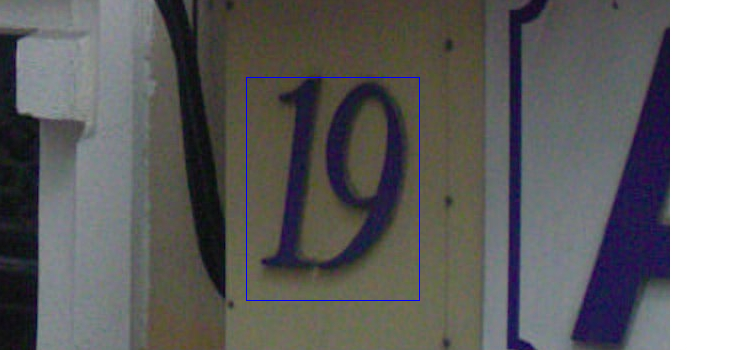

In [25]:
from PIL import Image, ImageDraw

def display_bbox(image_path, bbox):
    """ Helper function to display a single image and bounding box
    """
    image = Image.open(image_path)
    
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0'], bbox['y0'], bbox['x1'], bbox['y1']], outline="blue")
    #plt.imshow(image)
    
    return image


# Select a image and bounding box
image = '/kaggle/input/street-view-house-numbers/train/train/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)


/opt/conda/lib/python3.10/site-packages/PIL/ImageDraw.py:296: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.draw.draw_rectangle(xy, ink, 0, width)


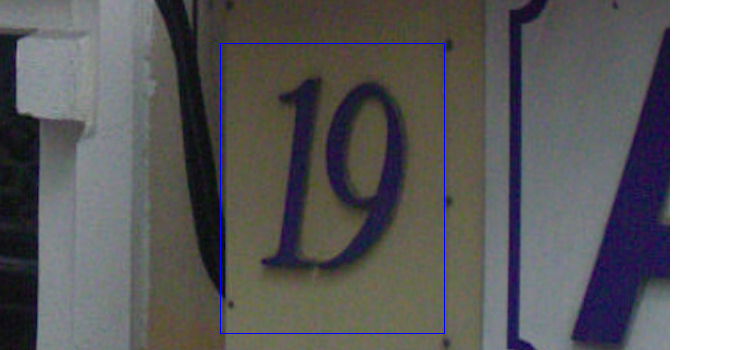

In [26]:
# Calculate the increase in both directions
df['x_increase'] = ((df['x1'] - df['x0']) * 0.3) / 2.
df['y_increase'] = ((df['y1'] - df['y0']) * 0.3) / 2.

# Apply the increase in all four directions
df['x0'] = (df['x0'] - df['x_increase']).astype('int')
df['y0'] = (df['y0'] - df['y_increase']).astype('int')
df['x1'] = (df['x1'] + df['x_increase']).astype('int')
df['y1'] = (df['y1'] + df['y_increase']).astype('int')


# Select the dataframe row corresponding to our image
image = '/kaggle/input/street-view-house-numbers/train/train/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

In [27]:
def get_image_size(filepath):
    """Returns the image size in pixels given as a 2-tuple (width, height)
    """
    image = Image.open(filepath)
    return image.size 

def get_image_sizes(folder):
    """Returns a DataFrame with the file name and size of all images contained in a folder
    """
    image_sizes = []
    
    # Get all .png images contained in the folder
    images = [img for img in os.listdir(folder) if img.endswith('.png')]
    
    # Get image size of every individual image
    for image in images:
        w, h = get_image_size(folder + image)
        image_size = {'filename': folder + image, 'image_width': w, 'image_height': h}
        image_sizes.append(image_size)
        
    # Return results as a pandas DataFrame
    return pd.DataFrame(image_sizes)


# Extract the image sizes
train_sizes = get_image_sizes('/kaggle/input/street-view-house-numbers/train/train/')
test_sizes = get_image_sizes('/kaggle/input/street-view-house-numbers/test/test/')
extra_sizes = get_image_sizes('/kaggle/input/street-view-house-numbers/extra/extra/')

# Concatenate all the information in a single file
image_sizes = pd.concat([train_sizes, test_sizes, extra_sizes])

# Delete old dataframes
#train_sizes, test_sizes, extra_sizes

# Display 10 image sizes
image_sizes.head(10)

,filename,image_width,image_height
0,/kaggle/input/street-view-house-numbers/train/train/27147.png,77,38
1,/kaggle/input/street-view-house-numbers/train/train/32352.png,48,14
2,/kaggle/input/street-view-house-numbers/train/train/21130.png,103,43
3,/kaggle/input/street-view-house-numbers/train/train/22897.png,166,93
4,/kaggle/input/street-view-house-numbers/train/train/9273.png,71,34
5,/kaggle/input/street-view-house-numbers/train/train/18966.png,195,95
6,/kaggle/input/street-view-house-numbers/train/train/22069.png,102,41
7,/kaggle/input/street-view-house-numbers/train/train/32860.png,83,37
8,/kaggle/input/street-view-house-numbers/train/train/27326.png,159,89
9,/kaggle/input/street-view-house-numbers/train/train/30577.png,137,61


In [28]:
print("Bounding boxes", df.shape)
print("Image sizes", image_sizes.shape)
print('')

# Inner join the datasets on filename
df = pd.merge(df, image_sizes, on='filename', how='inner')

print("Combined", df.shape)

# Delete the image size df
del image_sizes

# Store checkpoint
df.to_csv("/kaggle/working/image_data.csv", index=False)
#df = pd.read_csv('/kaggle/working/image_data.csv/image_data.csv')

df.head()

Bounding boxes (248823, 9)
Image sizes (248823, 3)

Combined (248823, 11)


,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,/kaggle/input/street-view-house-numbers/extra/extra/1.png,8,7,141,141,"[4.0, 7.0, 8.0]",3,15.30,15.45,166,141
1,/kaggle/input/street-view-house-numbers/extra/extra/10.png,20,0,56,36,"[4.0, 4.0, 4.0]",3,4.05,4.05,52,41
2,/kaggle/input/street-view-house-numbers/extra/extra/100.png,13,-3,50,34,"[5.0, 3.0, 5.0]",3,4.20,4.35,51,32
3,/kaggle/input/street-view-house-numbers/extra/extra/1000.png,19,2,38,44,"[2.0, 6.0]",2,2.10,4.95,51,49
4,/kaggle/input/street-view-house-numbers/extra/extra/10000.png,13,7,44,38,"[2.0, 10.0, 10.0]",3,3.60,3.60,55,44


In [29]:
# Correct bounding boxes not contained by image
df.loc[df['x0'] < 0, 'x0'] = 0
df.loc[df['y0'] < 0, 'y0'] = 0
df.loc[df['x1'] > df['image_width'], 'x1'] = df['image_width']
df.loc[df['y1'] > df['image_height'], 'y1'] = df['image_width']

df.head()

,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,/kaggle/input/street-view-house-numbers/extra/extra/1.png,8,7,141,141,"[4.0, 7.0, 8.0]",3,15.30,15.45,166,141
1,/kaggle/input/street-view-house-numbers/extra/extra/10.png,20,0,52,36,"[4.0, 4.0, 4.0]",3,4.05,4.05,52,41
2,/kaggle/input/street-view-house-numbers/extra/extra/100.png,13,0,50,51,"[5.0, 3.0, 5.0]",3,4.20,4.35,51,32
3,/kaggle/input/street-view-house-numbers/extra/extra/1000.png,19,2,38,44,"[2.0, 6.0]",2,2.10,4.95,51,49
4,/kaggle/input/street-view-house-numbers/extra/extra/10000.png,13,7,44,38,"[2.0, 10.0, 10.0]",3,3.60,3.60,55,44


In [30]:
df.num_digits.value_counts(sort=False)

num_digits
3    117561
2     98212
4     15918
1     17005
5       126
6         1
Name: count, dtype: int64

In [31]:
# Keep only images with less than 6 digits
df = df[df.num_digits < 6]

In [32]:
df[['image_width', 'image_height']].describe().round(decimals=2)

,image_width,image_height
count,248822.00,248822.00
mean,107.93,60.88
std,63.22,32.39
min,22.00,12.00
25%,69.00,40.00
50%,92.00,53.00
75%,127.00,74.00
max,1083.00,516.00


In [33]:
df=df.drop(['image_width_x','image_height_x','image_width_y','image_height_y'],axis=1)

KeyError: "['image_width_x', 'image_height_x', 'image_width_y', 'image_height_y'] not found in axis"

In [34]:
df

,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,/kaggle/input/street-view-house-numbers/extra/extra/1.png,8,7,141,141,"[4.0, 7.0, 8.0]",3,15.30,15.45,166,141
1,/kaggle/input/street-view-house-numbers/extra/extra/10.png,20,0,52,36,"[4.0, 4.0, 4.0]",3,4.05,4.05,52,41
2,/kaggle/input/street-view-house-numbers/extra/extra/100.png,13,0,50,51,"[5.0, 3.0, 5.0]",3,4.20,4.35,51,32
3,/kaggle/input/street-view-house-numbers/extra/extra/1000.png,19,2,38,44,"[2.0, 6.0]",2,2.10,4.95,51,49
4,/kaggle/input/street-view-house-numbers/extra/extra/10000.png,13,7,44,38,"[2.0, 10.0, 10.0]",3,3.60,3.60,55,44
...,...,...,...,...,...,...,...,...,...,...,...
248818,/kaggle/input/street-view-house-numbers/train/train/9995.png,113,12,184,105,"[3.0, 2.0]",2,8.10,10.80,243,107
248819,/kaggle/input/street-view-house-numbers/train/train/9996.png,36,8,78,47,"[7.0, 2.0]",2,4.95,4.50,114,55
248820,/kaggle/input/street-view-house-numbers/train/train/9997.png,38,4,103,59,"[6.0, 7.0]",2,7.50,6.30,141,61
248821,/kaggle/input/street-view-house-numbers/train/train/9998.png,24,0,55,38,"[1.0, 3.0]",2,3.60,4.35,76,39


In [35]:
y_train

NameError: name 'y_train' is not defined

In [36]:
from imageio import imread
from skimage.transform import resize
import cv2
def crop_and_resize(image, img_size):
    """ Crop and resize an image
    """
    image_data = imread(image['filename'])
    
    crop = image_data[image['y0']:image['y1'], image['x0']:image['x1'], :]
    
    #print(cv2.resize(crop, img_size))
    return cv2.resize(crop, img_size)


def create_dataset(df, img_size):
    """ Helper function for converting images into a numpy array
    """
    # Initialize the numpy arrays (0's are stored as 10's)
    X = np.zeros(shape=(df.shape[0], img_size[0], img_size[0], 3), dtype='uint8')
    y = np.full((df.shape[0], 5), 10, dtype=int)
    
    # Iterate over all images in the pandas dataframe (slow!)
    for i, (index, image) in enumerate(df.iterrows()):
        
        # Get the image data
        X[i] = crop_and_resize(image, img_size)
        #print(X[i])
        # Get the label list as an array
        labels = np.array((image['labels']))
        labels_numeric = []

        for label in labels:
            label = label.strip("[]")  # Remove square brackets if present
            if "." in label:
                labels_numeric.append(float(label))
            else:
                labels_numeric.append(int(label))
        labels=np.array(labels_numeric)
        #print(type(labels[0]))
        #labels = [int(float(label)) for label in labels]
        #print((labels))   
        # Store 0's as 0 (not 10)
        #labels=np.array([1.0,9.0])
        labels[labels==10] = 0
        
        # Embed labels into label array
        y[i,0:labels.shape[0]] = labels
    #print(X)    
    # Return data and labels   
    return X, y


# Change this to select a different image size
image_size = (32, 32)

# Get cropped images and labels (this might take a while...)
X_train, y_train = create_dataset(df[df.filename.str.contains('train')], image_size)
X_test, y_test = create_dataset(df[df.filename.str.contains('test')], image_size)
X_extra, y_extra = create_dataset(df[df.filename.str.contains('extra')], image_size)

# We no longer need the dataframe
#del df

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Extra', X_extra.shape, y_extra.shape)

/tmp/ipykernel_32/3689117484.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_data = imread(image['filename'])


Training (33401, 32, 32, 3) (33401, 5)
Test (13068, 32, 32, 3) (13068, 5)
Extra (202353, 32, 32, 3) (202353, 5)


In [37]:
df

,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_width,image_height
0,/kaggle/input/street-view-house-numbers/extra/extra/1.png,8,7,141,141,"[4.0, 7.0, 8.0]",3,15.30,15.45,166,141
1,/kaggle/input/street-view-house-numbers/extra/extra/10.png,20,0,52,36,"[4.0, 4.0, 4.0]",3,4.05,4.05,52,41
2,/kaggle/input/street-view-house-numbers/extra/extra/100.png,13,0,50,51,"[5.0, 3.0, 5.0]",3,4.20,4.35,51,32
3,/kaggle/input/street-view-house-numbers/extra/extra/1000.png,19,2,38,44,"[2.0, 6.0]",2,2.10,4.95,51,49
4,/kaggle/input/street-view-house-numbers/extra/extra/10000.png,13,7,44,38,"[2.0, 10.0, 10.0]",3,3.60,3.60,55,44
...,...,...,...,...,...,...,...,...,...,...,...
248818,/kaggle/input/street-view-house-numbers/train/train/9995.png,113,12,184,105,"[3.0, 2.0]",2,8.10,10.80,243,107
248819,/kaggle/input/street-view-house-numbers/train/train/9996.png,36,8,78,47,"[7.0, 2.0]",2,4.95,4.50,114,55
248820,/kaggle/input/street-view-house-numbers/train/train/9997.png,38,4,103,59,"[6.0, 7.0]",2,7.50,6.30,141,61
248821,/kaggle/input/street-view-house-numbers/train/train/9998.png,24,0,55,38,"[1.0, 3.0]",2,3.60,4.35,76,39


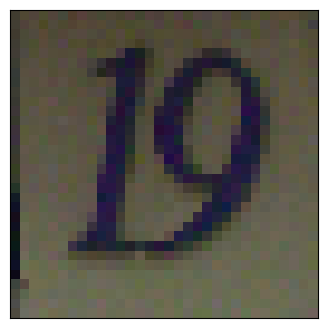

In [38]:
# Plot a cropped image
plt.imshow(X_train[0])
plt.xticks([]); 
plt.yticks([]);
plt.show()

In [39]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Helper function for plotting nrows * ncols images
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted label
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number)  
        ax.imshow(images[i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

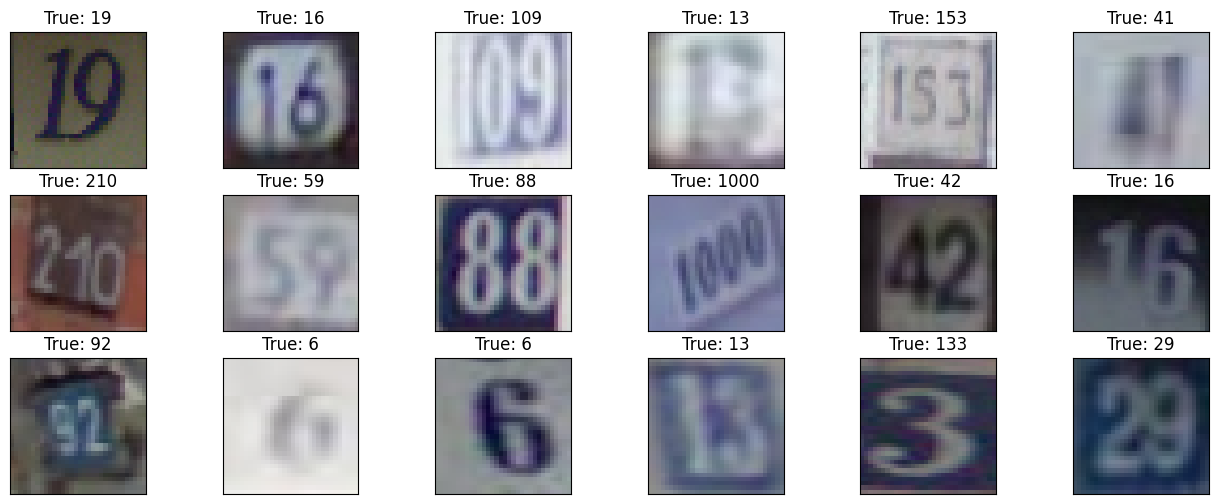

In [40]:
# Display images from the training set
plot_images(X_train, 3, 6, y_train);

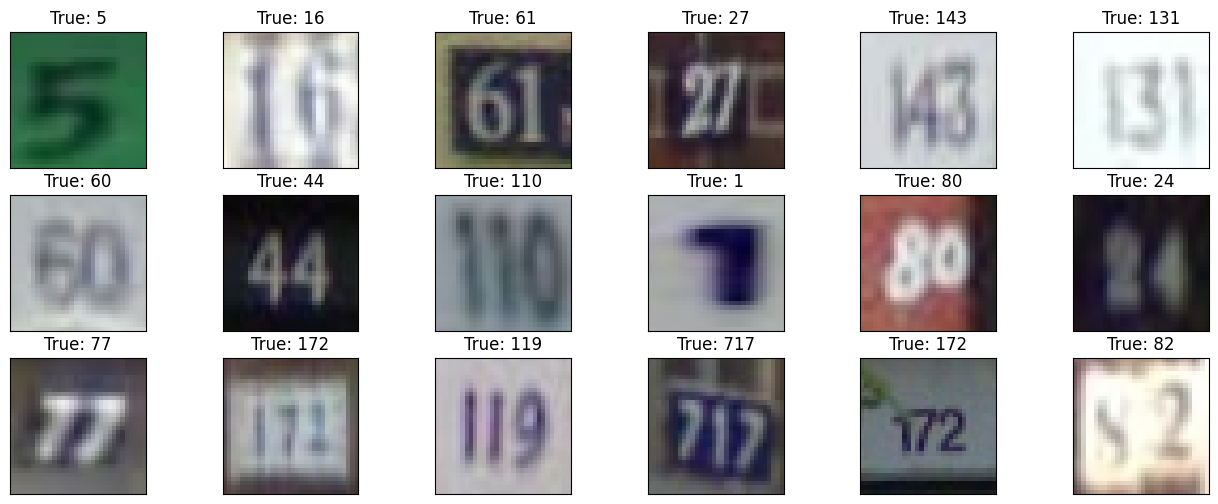

In [41]:
plot_images(X_test, 3, 6, y_test);

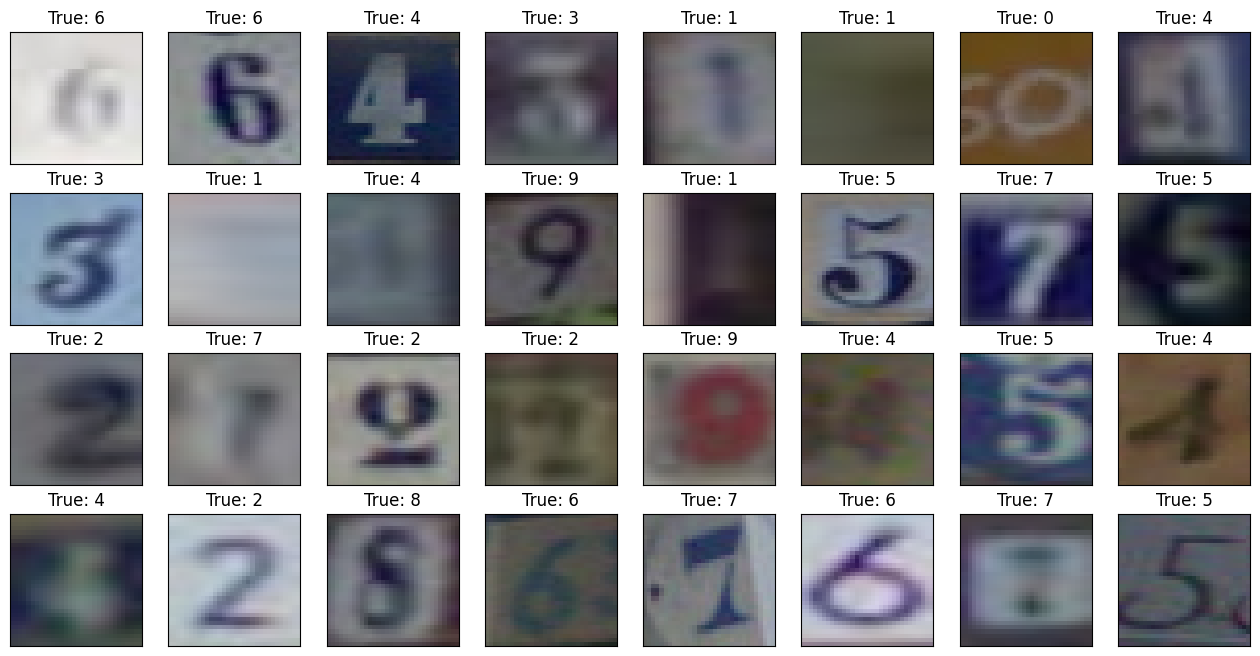

In [42]:
# Find some images containing 1 digit
single_digit = (y_train != 10).sum(1) == 1

# Display some exaples
plot_images(X_train[single_digit], 4, 8, y_train[single_digit]);

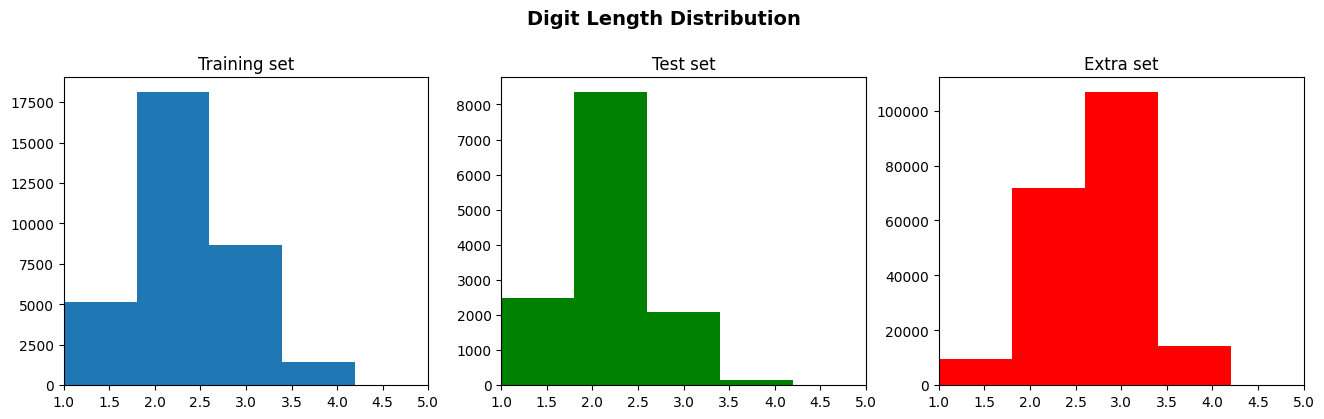

In [43]:
# Initialize the subplotgrid
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

# Set the main figure title
fig.suptitle('Digit Length Distribution', fontsize=14, fontweight='bold', y=1.05)

# Sequence length distribution - training set 
ax1.hist((y_train != 10).sum(1), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(1, 5)

# Sequence length distribution - test set 
ax2.hist((y_test != 10).sum(1), bins=5, color='g')
ax2.set_title("Test set");

# Sequence length distribution - extra set 
ax3.hist((y_extra != 10).sum(1), bins=5, color='r')
ax3.set_title("Extra set");

In [44]:
def random_sample(N, K):
    """Return a boolean mask of size N with K selections
    """
    mask = np.array([True]*K + [False]*(N-K))
    np.random.shuffle(mask)
    return mask

# Pick 4000 training and 2000 extra samples
sample1 = random_sample(X_train.shape[0], 3000)
sample2 = random_sample(X_extra.shape[0], 2000)

# Create valdidation from the sampled data
X_val = np.concatenate([X_train[sample1], X_extra[sample2]])
y_val = np.concatenate([y_train[sample1], y_extra[sample2]])

# Keep the data not contained by sample
X_train = np.concatenate([X_train[~sample1], X_extra[~sample2]])
y_train = np.concatenate([y_train[~sample1], y_extra[~sample2]])

# Moved to validation and training set
del X_extra, y_extra 

print("Training", X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)

Training (230754, 32, 32, 3) (230754, 5)
Validation (5000, 32, 32, 3) (5000, 5)


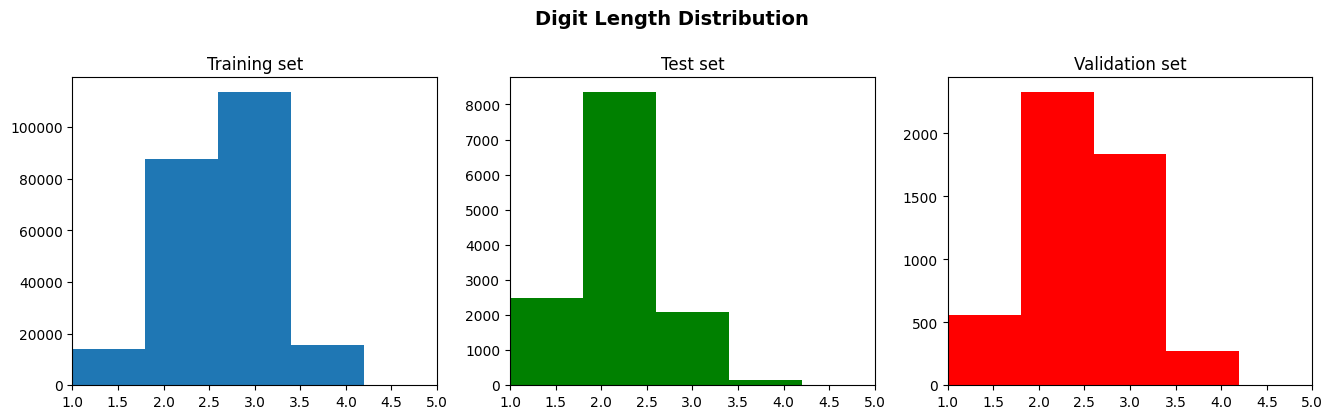

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

fig.suptitle('Digit Length Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist((y_train != 10).sum(1), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(1, 5)

ax2.hist((y_test != 10).sum(1), bins=5, color='g')
ax2.set_title("Test set");

ax3.hist((y_val != 10).sum(1), bins=5, color='r')
ax3.set_title("Validation set");

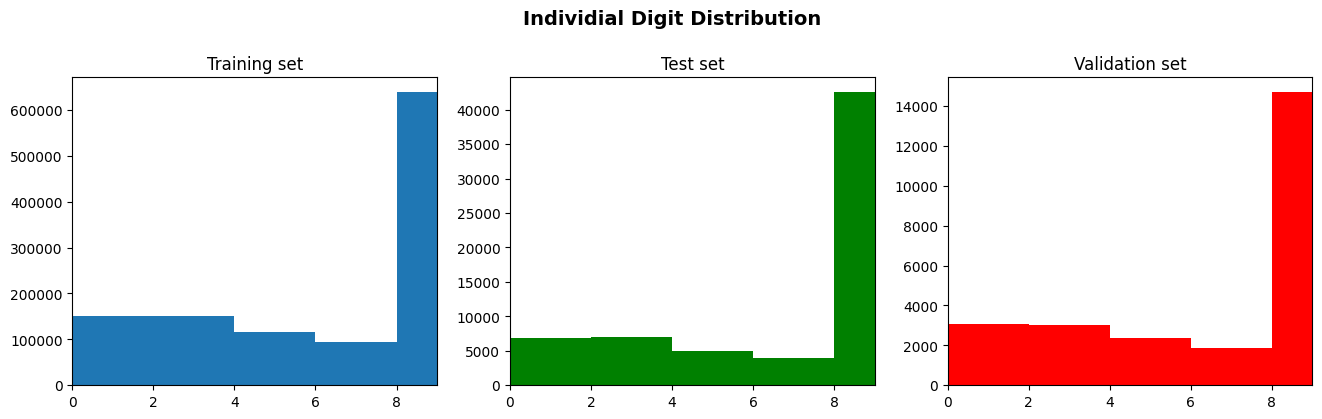

In [46]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

fig.suptitle('Individial Digit Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train.flatten(), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(0, 9)

ax2.hist(y_test.flatten(), bins=5, color='g')
ax2.set_title("Test set");

ax3.hist(y_val.flatten(), bins=5, color='r')
ax3.set_title("Validation set");

In [ ]:
# Create file
h5f = h5py.File('/kaggle/working/SVHN_multi.h5', 'w')

# Store the datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('valid_dataset', data=X_val)
h5f.create_dataset('valid_labels', data=y_val)

# Close the file
h5f.close()

In [48]:
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    greyscale = np.dot(images, [0.2989, 0.5870, 0.1140])
    return np.expand_dims(greyscale, axis=3)


# Transform the images to greyscale
X_train = rgb2gray(X_train).astype(np.float32)
X_test = rgb2gray(X_test).astype(np.float32)
X_val = rgb2gray(X_val).astype(np.float32)

In [ ]:
# Create file
h5f = h5py.File('/kaggle/input/svhn-multi-grey/SVHN_multi_grey.h5', 'w')

# Store the datasets
h5f.create_dataset('train_dataset', data=X_train)
h5f.create_dataset('train_labels', data=y_train)
h5f.create_dataset('test_dataset', data=X_test)
h5f.create_dataset('test_labels', data=y_test)
h5f.create_dataset('valid_dataset', data=X_val)
h5f.create_dataset('valid_labels', data=y_val)

# Close the file
h5f.close()

### CNN MODEL

In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import seaborn as sns
import numpy as np
import time
import os
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

print("Tensorflow version: " + tf.__version__)


Tensorflow version: 2.12.0


#### print("Tensorflow version: " + tf.__version__)

In [2]:
# Open the HDF5 file containing the datasets
h5f = h5py.File('/kaggle/input/svhn-multi-grey/SVHN_multi_grey.h5','r')

# Extract the datasets
X_train = h5f['train_dataset'][:]
y_train = h5f['train_labels'][:]
X_val = h5f['valid_dataset'][:]
y_val = h5f['valid_labels'][:]
X_test = h5f['test_dataset'][:]
y_test = h5f['test_labels'][:]

# Close the file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (230754, 32, 32, 1) (230754, 5)
Validation set (5000, 32, 32, 1) (5000, 5)
Test set (13068, 32, 32, 1) (13068, 5)


In [3]:
# Get the data dimensions
_, img_height, img_width, num_channels = X_train.shape

# ... and label information
num_digits, num_labels = y_train.shape[1], len(np.unique(y_train))

In [4]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

print('Training set', X_train.shape, y_train.shape)

Training set (235754, 32, 32, 1) (235754, 5)


In [5]:
from sklearn.utils import shuffle

# Randomly shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

In [6]:
def subtract_mean(a):
    """ Helper function for subtracting the mean of every image
    """
    for i in range(a.shape[0]):
        a[i] -= a[i].mean()
    return a


# Subtract the mean from every image
X_train = subtract_mean(X_train)
X_test = subtract_mean(X_test)
X_val = subtract_mean(X_val)

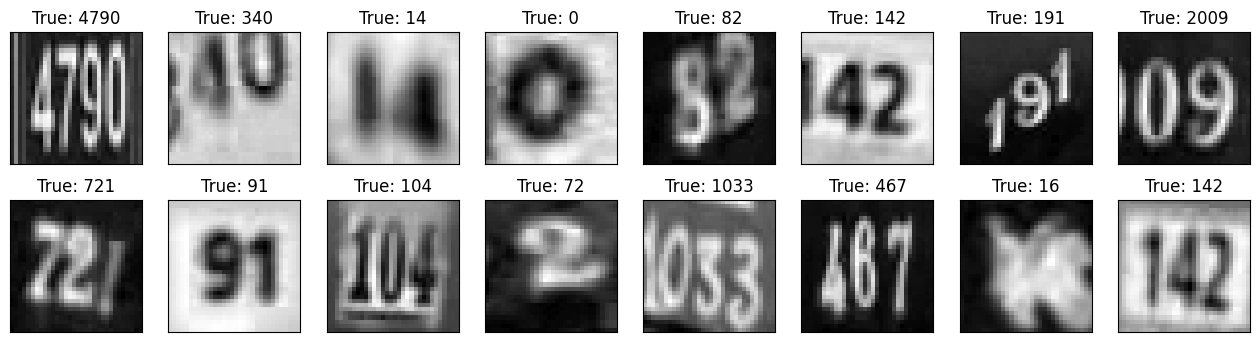

In [7]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    
    # Initialize figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Pretty string with actual number
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted number
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number) 
            
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# Plot some images from the training set
plot_images(X_train, 2, 8, y_train)

In [8]:
import numpy as np
import cv2
import os
import copy
import math
import warnings
import tensorflow as tf
import h5py
import pandas as pd
from tensorflow.python.layers.normalization import BatchNormalization
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D ,Activation,MaxPooling2D
from tensorflow.keras.optimizers import Adam
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, History
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras import backend as K
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
import numpy as np

#from load_data import load_images
#from load_data_negatives import load_images as load_images_negative
#from cnn import build_cnn_model

In [9]:

    inputShape = (32, 32, 1)
    inputs = Input(shape=inputShape)

    x = Conv2D(32, (5, 5), padding="same",activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", strides =(2,2))(x)
    #x = Dropout(0.25)(x)

    x = Conv2D(32, (5, 5), padding="same",activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", strides=(1,1))(x)
    #x = Dropout(0.25)(x)

    x = Conv2D(64, (5, 5), padding="same",activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", strides=(2,2))(x)
    #x = Dropout(0.25)(x)

    x = Conv2D(64, (5, 5), padding="same",activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", strides=(1,1))(x)
    #x = Dropout(0.25)(x)

    x = Conv2D(128, (5, 5), padding="same",activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same",strides=(2,2))(x)
    #x = Dropout(0.25)(x)

    x = Conv2D(128, (5, 5), padding="same",activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", strides=(1,1))(x)
    #x = Dropout(0.25)(x)

    x = Conv2D(128, (5, 5), padding="same",activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", strides=(2,2))(x)
    #x = Dropout(0.25)(x)

    x = Conv2D(128, (5, 5), padding="same",activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same",strides=(1,1))(x)
    #x = Dropout(0.25)(x)

    x = Flatten()(x)

    x = Dense(256,activation='relu')(x)
    x = Dropout(0.25)(x)

    x = Dense(256,activation='relu')(x)
    x = Dropout(0.25)(x)

    digit1 = Dense(11,name='digit1',activation='softmax')(x)

    digit2 = Dense(11,name='digit2',activation='softmax')(x)

    digit3 = Dense(11,name='digit3',activation='softmax')(x)

    digit4 = Dense(11,name='digit4',activation='softmax')(x)

    digit5 = Dense(11,name='digit5',activation='softmax')(x)
    #y_pred=tf.stack([digit1,digit2,digit3,digit4,digit4])
    #y_pred_cls = tf.transpose(tf.argmax(y_pred, axis=2))

    #length = Dense(6)(x)
    #length = Activation('softmax', name="length")(length)

    model = Model(inputs=inputs, outputs=[digit1, digit2, digit3, digit4, digit5], name="multidigit_classifier")


In [10]:
model.summary()

Model: "multidigit_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
tf.compat.v1.nn.fused_batch_nor ((None, 32, 32, 32), 0           tf.cast[0][0]                    
______________________________________________________________________________

In [11]:
loss1 = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss2 = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss3 = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss4 = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss5 = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [12]:
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

In [13]:
losses = {
    "digit1": loss1,
    "digit2": loss2,
    "digit3": loss3,
    "digit4": loss4,
    "digit5": loss5,
}


In [14]:
model.compile(loss=losses, optimizer='adam', metrics=metrics)

In [15]:
y= {"digit1": y_train[:,0],
    "digit2": y_train[:,1], 
    "digit3": y_train[:,2],
    "digit4": y_train[:,3],
    "digit5": y_train[:,4]}

In [16]:
history = model.fit(X_train,y=y,epochs=5,batch_size=64,verbose=2      
                    )

Epoch 1/5
3684/3684 - 1693s - loss: 4.9402 - digit1_loss: 1.4758 - digit2_loss: 1.8465 - digit3_loss: 1.3161 - digit4_loss: 0.2900 - digit5_loss: 0.0117 - digit1_accuracy: 0.4878 - digit2_accuracy: 0.3366 - digit3_accuracy: 0.5719 - digit4_accuracy: 0.9349 - digit5_accuracy: 0.9991
Epoch 2/5
3684/3684 - 1691s - loss: 3.2157 - digit1_loss: 0.9999 - digit2_loss: 1.1586 - digit3_loss: 0.8443 - digit4_loss: 0.2069 - digit5_loss: 0.0060 - digit1_accuracy: 0.6816 - digit2_accuracy: 0.6124 - digit3_accuracy: 0.7296 - digit4_accuracy: 0.9459 - digit5_accuracy: 0.9995
Epoch 3/5
3684/3684 - 1931s - loss: 2.7360 - digit1_loss: 0.8858 - digit2_loss: 0.9460 - digit3_loss: 0.7124 - digit4_loss: 0.1861 - digit5_loss: 0.0058 - digit1_accuracy: 0.7294 - digit2_accuracy: 0.7109 - digit3_accuracy: 0.7828 - digit4_accuracy: 0.9521 - digit5_accuracy: 0.9995
Epoch 4/5
3684/3684 - 1678s - loss: 2.4708 - digit1_loss: 0.8250 - digit2_loss: 0.8338 - digit3_loss: 0.6334 - digit4_loss: 0.1726 - digit5_loss: 0.006

In [64]:
X_test.shape

(13068, 32, 32, 1)

In [28]:
prediction=model.predict(X_test)

In [33]:
np.array(prediction_class).shape


(13068, 5)

In [32]:
prediction_class=tf.transpose(tf.argmax(prediction, axis=2))

In [31]:
np.array(y_test).shape

(13068, 5)

In [35]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

In [36]:

print("Test accuracy: %.4f" % accuracy(prediction_class, y_test))

Test accuracy: 89.1384


In [27]:
prediction_class

<tf.Tensor: shape=(10, 5), dtype=int64, numpy=
array([[ 5, 10, 10, 10, 10],
       [ 1,  6, 10, 10, 10],
       [ 6,  1, 10, 10, 10],
       [ 1,  2,  1, 10, 10],
       [ 1,  4,  3, 10, 10],
       [ 1,  3,  1, 10, 10],
       [ 6,  0, 10, 10, 10],
       [ 4,  4, 10, 10, 10],
       [ 1,  1,  0, 10, 10],
       [ 7, 10, 10, 10, 10]])>

In [41]:
correct = np.array([tf.reduce_all(tf.equal(a, b)).numpy() for a, b in zip(prediction_class, y_test)])

# Select the incorrectly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = prediction_class[correct]



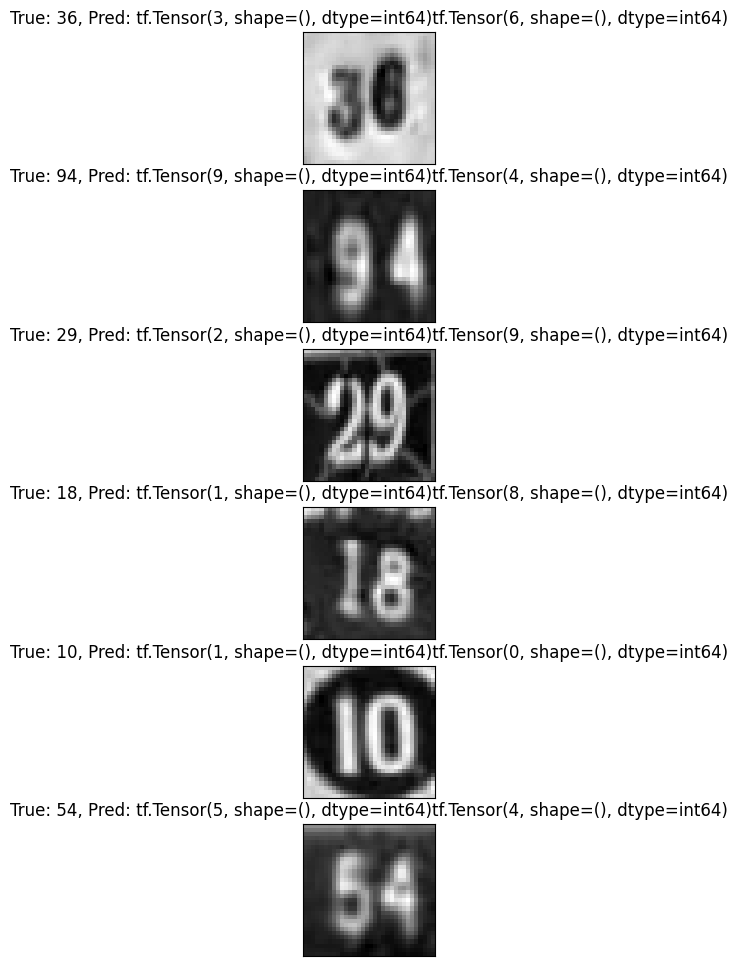

In [43]:
# Plot the mis-classified examples
plot_images(images, 6, 1, cls_true, cls_pred);

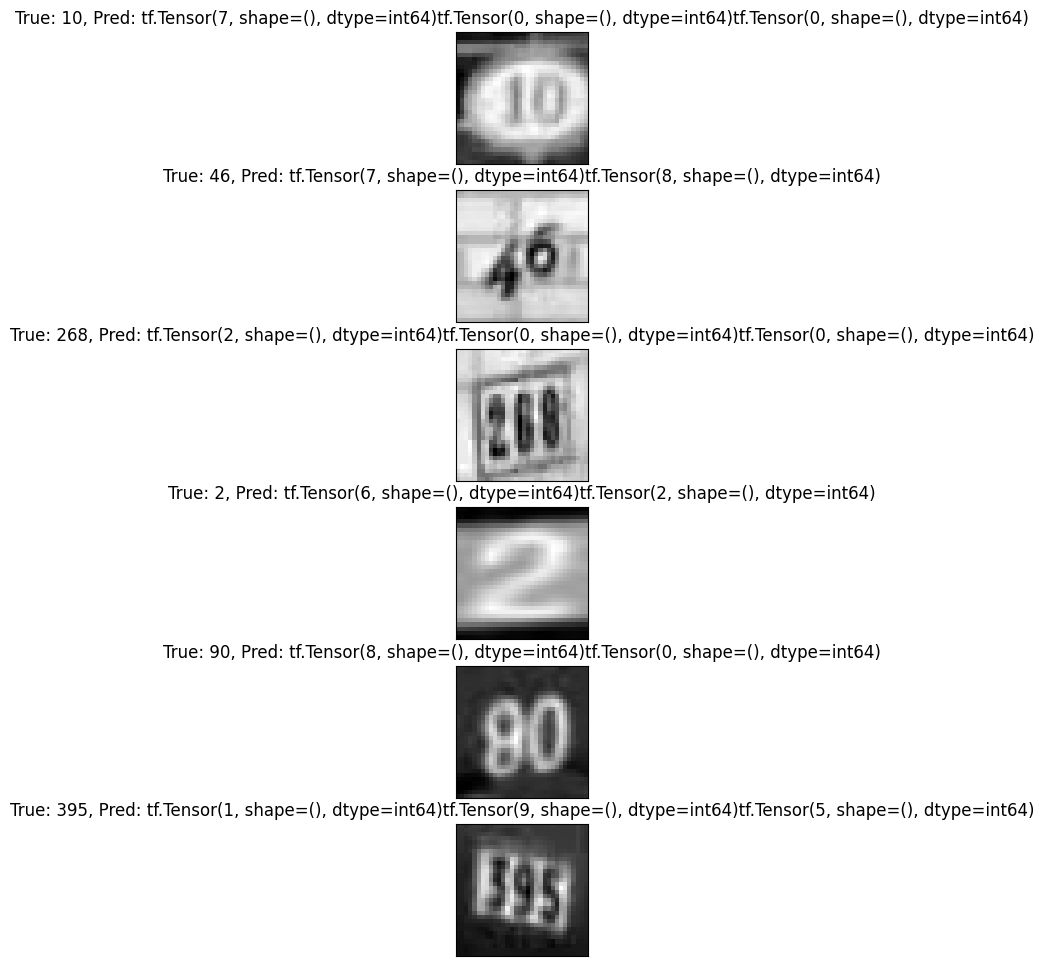

In [44]:
incorrect = np.invert(correct)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = prediction_class[incorrect]
# Plot the mis-classified examples
plot_images(images, 6, 1, cls_true, cls_pred);


In [59]:
from sklearn.metrics import accuracy_score

# Find the position of the non missing labels
y_test_flat = tf.reshape(y_test, [-1])
prediction_class_flat = tf.reshape(prediction_class, [-1])

# Get indices of non-zero values
non_zero_indices = tf.where(y_test_flat != 10)

# Convert the TensorFlow tensors to NumPy arrays for use with accuracy_score
y_test_flat_numpy = y_test_flat.numpy()
prediction_class_flat_numpy = prediction_class_flat.numpy()

# Calculate the accuracy on the individual digit level
accuracy = accuracy_score(y_test_flat_numpy[non_zero_indices], prediction_class_flat_numpy[non_zero_indices])

In [60]:
accuracy

0.7730485556238476

/tmp/ipykernel_32/1285963496.py:16: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0


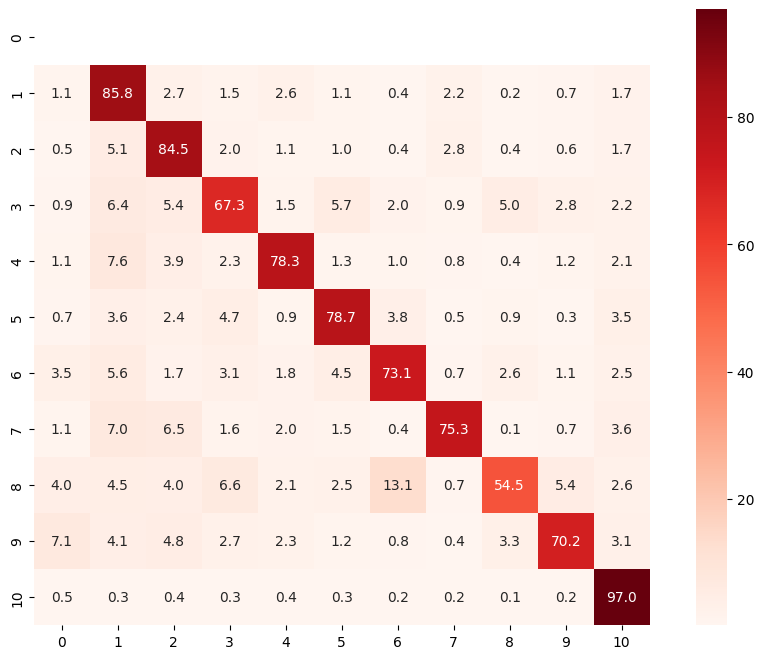

In [62]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

y_test_flat = tf.reshape(y_test, [-1])
prediction_class_flat = tf.reshape(prediction_class, [-1])

# Only select non-zero values
non_zero = y_test_flat != 0

# Calculate the confusion matrix
cm = confusion_matrix(y_test_flat[non_zero], prediction_class_flat[non_zero])

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

In [ ]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"

In [ ]:
model.save("/kaggle/working/my_model.h5")

In [ ]:
new_model = tf.keras.models.load_model('/kaggle/working/my_model.h5')

In [ ]:
model.load_weights('/kaggle/working/my_model.keras')